In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
pd.options.mode.chained_assignment = None
%matplotlib inline

In [5]:
import dgl
from dgl.data import DGLDataset
import torch
import os

class BNU1Dataset(DGLDataset):
    def __init__(self):
        super().__init__(name='synthetic')

    def process(self):
        edges = pd.read_csv('./BNU1_dMRI/dMRI_brain_graph_edges_fused.csv')
        properties = pd.read_csv('./BNU1_dMRI/dMRI_brain_graph_properties.csv')
        self.graphs = []
        self.labels = []

        # Create a graph for each graph ID from the edges table.
        # First process the properties table into two dictionaries with graph IDs as keys.
        # The label and number of nodes are values.
        label_dict = {}
        num_nodes_dict = {}
        for _, row in properties.iterrows():
            label_dict[row['graph_id']] = row['label']
            num_nodes_dict[row['graph_id']] = row['num_nodes']

        # For the edges, first group the table by graph IDs.
        edges_group = edges.groupby('graph_id')

        # For each graph ID...
        for graph_id in edges_group.groups:
            # Find the edges as well as the number of nodes and its label.
            edges_of_id = edges_group.get_group(graph_id)
            src = edges_of_id['source'].to_numpy()
            dst = edges_of_id['target'].to_numpy()
            num_nodes = num_nodes_dict[graph_id]
            label = label_dict[graph_id]

            # Create a graph and add it to the list of graphs and labels.
            g = dgl.graph((src, dst), num_nodes=num_nodes)
            g = dgl.add_self_loop(g)
            self.graphs.append(g)
            self.labels.append(label)

        # Convert the label list to tensor for saving.
        self.labels = torch.LongTensor(self.labels)

    def __getitem__(self, i):
        return self.graphs[i], self.labels[i]

    def __len__(self):
        return len(self.graphs)

dataset = BNU1Dataset()
graph, label = dataset[0]
print(graph, label)

Graph(num_nodes=70, num_edges=160,
      ndata_schemes={}
      edata_schemes={}) tensor(1)


In [6]:
import dgl.nn.pytorch as dglnn
from dgl.data.utils import split_dataset
import torch.nn as nn
import torch.nn.functional as F

class GCN_Classifier(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_classes):
        super(GCN_Classifier, self).__init__()
        self.conv1 = dglnn.GraphConv(in_dim, hidden_dim)
        self.conv2 = dglnn.GraphConv(hidden_dim, hidden_dim)
#         self.conv3 = dglnn.GraphConv(hidden_dim, hidden_dim)
        self.classify = nn.Linear(hidden_dim, n_classes)

    def forward(self, g):
        # Use node degree as the initial node feature. For undirected graphs, the in-degree
        # is the same as the out_degree.
        h = g.in_degrees().view(-1, 1).float()
        # Perform graph convolution and activation function.
        h = F.relu(self.conv1(g, h))
        h = F.relu(self.conv2(g, h))
#         h = F.relu(self.conv3(g, h))
        g.ndata['h'] = h
        # Calculate graph representation by averaging all the node representations.
        hg = dgl.mean_nodes(g, 'h')
        return self.classify(hg)

trainset, validset, testset = split_dataset(dataset, shuffle=True)
        
from dgl.dataloading import GraphDataLoader
import torch.optim as optim

Epoch 0, loss 0.7176
Epoch 1, loss 0.7168
Epoch 2, loss 0.7189
Epoch 3, loss 0.7165
Epoch 4, loss 0.7160
Epoch 5, loss 0.7152
Epoch 6, loss 0.7126
Epoch 7, loss 0.7156
Epoch 8, loss 0.7133
Epoch 9, loss 0.7098
Epoch 10, loss 0.7116
Epoch 11, loss 0.7114
Epoch 12, loss 0.7124
Epoch 13, loss 0.7108
Epoch 14, loss 0.7086
Epoch 15, loss 0.7104
Epoch 16, loss 0.7082
Epoch 17, loss 0.7073
Epoch 18, loss 0.7081
Epoch 19, loss 0.7070
Epoch 20, loss 0.7064
Epoch 21, loss 0.7076
Epoch 22, loss 0.7076
Epoch 23, loss 0.7070
Epoch 24, loss 0.7054
Epoch 25, loss 0.7055
Epoch 26, loss 0.7044
Epoch 27, loss 0.7037
Epoch 28, loss 0.7047
Epoch 29, loss 0.7048
Epoch 30, loss 0.7028
Epoch 31, loss 0.7023
Epoch 32, loss 0.7023
Epoch 33, loss 0.7015
Epoch 34, loss 0.7022
Epoch 35, loss 0.7022
Epoch 36, loss 0.7006
Epoch 37, loss 0.7004
Epoch 38, loss 0.7001
Epoch 39, loss 0.6999
Epoch 40, loss 0.6999
Epoch 41, loss 0.7001
Epoch 42, loss 0.6992
Epoch 43, loss 0.6996
Epoch 44, loss 0.6990
Epoch 45, loss 0.698

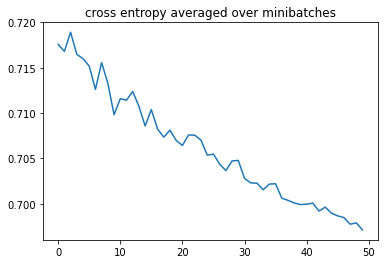

tensor([[1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.]]) tensor([[0],
        [1],
        [0],
        [0],
        [0],
        [1],
        [0]])
Accuracy of predictions on the test set: 42.8571%


In [10]:
data_loader = GraphDataLoader(trainset, batch_size=16, shuffle=True)

model = GCN_Classifier(1, 16, 2)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
model.train()

epoch_losses = []
for epoch in range(50):
    epoch_loss = 0
    for iter, (bg, label) in enumerate(data_loader):
        prediction = model(bg)
        loss = loss_func(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach().item()
    epoch_loss /= (iter + 1)
    print('Epoch {}, loss {:.4f}'.format(epoch, epoch_loss))
    epoch_losses.append(epoch_loss)

plt.title('cross entropy averaged over minibatches')
plt.plot(epoch_losses)
plt.show()

model.eval()
# Convert a list of tuples to two lists
test_X, test_Y = map(list, zip(*testset))
test_bg = dgl.batch(test_X)
test_Y = torch.tensor(test_Y).float().view(-1, 1)
probs_Y = torch.softmax(model(test_bg), 1)
pred_Y = torch.argmax(probs_Y, dim=1, keepdim=True)
# sampled_Y = torch.multinomial(probs_Y, 1)
# argmax_Y = torch.max(probs_Y, 1)[1].view(-1, 1)
print(test_Y, pred_Y)
print('Accuracy of predictions on the test set: {:.4f}%'.format(
    (test_Y == pred_Y.float()).sum().item() / len(test_Y) * 100))

Epoch 0, loss 1.4587
Epoch 1, loss 1.4349
Epoch 2, loss 1.3806
Epoch 3, loss 1.3788
Epoch 4, loss 1.3206
Epoch 5, loss 1.2799
Epoch 6, loss 1.2716
Epoch 7, loss 1.2639
Epoch 8, loss 1.2187
Epoch 9, loss 1.1848
Epoch 10, loss 1.1565
Epoch 11, loss 1.1433
Epoch 12, loss 1.1091
Epoch 13, loss 1.0756
Epoch 14, loss 1.0669
Epoch 15, loss 1.0274
Epoch 16, loss 1.0274
Epoch 17, loss 0.9805
Epoch 18, loss 0.9604
Epoch 19, loss 0.9324
Epoch 20, loss 0.9344
Epoch 21, loss 0.9088
Epoch 22, loss 0.8943
Epoch 23, loss 0.8819
Epoch 24, loss 0.8740
Epoch 25, loss 0.8567
Epoch 26, loss 0.8304
Epoch 27, loss 0.8124
Epoch 28, loss 0.8120
Epoch 29, loss 0.8103
Epoch 30, loss 0.7906
Epoch 31, loss 0.7871
Epoch 32, loss 0.7673
Epoch 33, loss 0.7619
Epoch 34, loss 0.7524
Epoch 35, loss 0.7467
Epoch 36, loss 0.7363
Epoch 37, loss 0.7319
Epoch 38, loss 0.7284
Epoch 39, loss 0.7213
Epoch 40, loss 0.7179
Epoch 41, loss 0.7148
Epoch 42, loss 0.7100
Epoch 43, loss 0.7062
Epoch 44, loss 0.7024
Epoch 45, loss 0.700

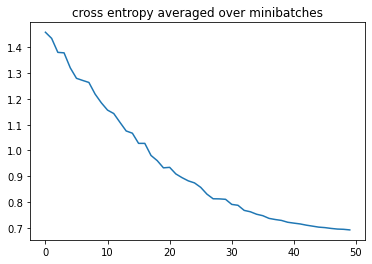

tensor([[1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.]]) tensor([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]])
Accuracy of predictions on the test set: 28.5714%


In [13]:
class GAT_Classifier(nn.Module):
    def __init__(self, in_dim, hidden_dim, num_heads, n_classes):
        super(GAT_Classifier, self).__init__()
        self.conv1 = dglnn.GATConv(in_dim, hidden_dim, num_heads, residual=True)
        self.conv2 = dglnn.GATConv(num_heads*hidden_dim, num_heads*hidden_dim, num_heads, residual=True)
        self.classify = nn.Linear(num_heads*num_heads*hidden_dim, n_classes)

    def forward(self, g):
        # Use node degree as the initial node feature. For undirected graphs, the in-degree
        # is the same as the out_degree.
        h = g.in_degrees().view(-1, 1).float()
        # Perform graph convolution and activation function.
        h = F.relu(self.conv1(g, h))
        h = torch.reshape(h, (h.shape[0], -1))
        h = F.relu(self.conv2(g, h))
        h = torch.reshape(h, (h.shape[0], -1))
        g.ndata['h'] = h
        # Calculate graph representation by averaging all the node representations.
        hg = dgl.mean_nodes(g, 'h')
        return self.classify(hg)


data_loader = GraphDataLoader(trainset, batch_size=16, shuffle=True)

model = GAT_Classifier(1, 16, 2, 2)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
model.train()

epoch_losses = []
for epoch in range(50):
    epoch_loss = 0
    for iter, (bg, label) in enumerate(data_loader):
        prediction = model(bg)
        loss = loss_func(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach().item()
    epoch_loss /= (iter + 1)
    print('Epoch {}, loss {:.4f}'.format(epoch, epoch_loss))
    epoch_losses.append(epoch_loss)

plt.title('cross entropy averaged over minibatches')
plt.plot(epoch_losses)
plt.show()

model.eval()
# Convert a list of tuples to two lists
test_X, test_Y = map(list, zip(*testset))
test_bg = dgl.batch(test_X)
test_Y = torch.tensor(test_Y).float().view(-1, 1)
probs_Y = torch.softmax(model(test_bg), 1)
pred_Y = torch.argmax(probs_Y, dim=1, keepdim=True)
# sampled_Y = torch.multinomial(probs_Y, 1)
# argmax_Y = torch.max(probs_Y, 1)[1].view(-1, 1)
print(test_Y, pred_Y)
print('Accuracy of predictions on the test set: {:.4f}%'.format(
    (test_Y == pred_Y.float()).sum().item() / len(test_Y) * 100))

Epoch 0, loss 5.0588
Epoch 1, loss 4.9093
Epoch 2, loss 4.8471
Epoch 3, loss 4.8168
Epoch 4, loss 4.6323
Epoch 5, loss 4.5261
Epoch 6, loss 4.4482
Epoch 7, loss 4.2886
Epoch 8, loss 4.1573
Epoch 9, loss 4.1233
Epoch 10, loss 4.0048
Epoch 11, loss 4.0092
Epoch 12, loss 3.8816
Epoch 13, loss 3.7600
Epoch 14, loss 3.6737
Epoch 15, loss 3.6561
Epoch 16, loss 3.4416
Epoch 17, loss 3.3766
Epoch 18, loss 3.2181
Epoch 19, loss 3.1751
Epoch 20, loss 3.0134
Epoch 21, loss 2.9616
Epoch 22, loss 2.9299
Epoch 23, loss 2.7640
Epoch 24, loss 2.7183
Epoch 25, loss 2.7104
Epoch 26, loss 2.4891
Epoch 27, loss 2.4844
Epoch 28, loss 2.3724
Epoch 29, loss 2.2598
Epoch 30, loss 2.2100
Epoch 31, loss 2.0599
Epoch 32, loss 2.0554
Epoch 33, loss 1.9238
Epoch 34, loss 1.8799
Epoch 35, loss 1.8189
Epoch 36, loss 1.7077
Epoch 37, loss 1.6439
Epoch 38, loss 1.5586
Epoch 39, loss 1.4713
Epoch 40, loss 1.4273
Epoch 41, loss 1.3809
Epoch 42, loss 1.3271
Epoch 43, loss 1.2410
Epoch 44, loss 1.1920
Epoch 45, loss 1.124

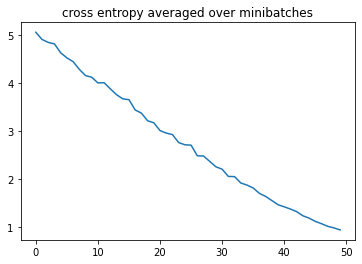

tensor([[1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.]]) tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]])
Accuracy of predictions on the test set: 71.4286%


In [14]:
class GIN_Classifier(nn.Module):
    def __init__(self, in_dim, hidden_dim, aggregator, n_classes):
        super(GIN_Classifier, self).__init__()
        lin_1 = torch.nn.Linear(in_dim, hidden_dim)
        lin_2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.conv1 = dglnn.GINConv(lin_1, aggregator)
        self.conv2 = dglnn.GINConv(lin_2, aggregator)
        self.classify = nn.Linear(hidden_dim, n_classes)

    def forward(self, g):
        # Use node degree as the initial node feature. For undirected graphs, the in-degree
        # is the same as the out_degree.
        h = g.in_degrees().view(-1, 1).float()
        # Perform graph convolution and activation function.
        h = F.relu(self.conv1(g, h))
#         h = torch.reshape(h, (h.shape[0], -1))
        h = F.relu(self.conv2(g, h))
#         h = torch.reshape(h, (h.shape[0], -1))
        g.ndata['h'] = h
        # Calculate graph representation by averaging all the node representations.
        hg = dgl.mean_nodes(g, 'h')
        return self.classify(hg)


data_loader = GraphDataLoader(trainset, batch_size=16, shuffle=True)

model = GIN_Classifier(1, 16, 'sum', 2)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
model.train()

epoch_losses = []
for epoch in range(50):
    epoch_loss = 0
    for iter, (bg, label) in enumerate(data_loader):
        prediction = model(bg)
        loss = loss_func(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach().item()
    epoch_loss /= (iter + 1)
    print('Epoch {}, loss {:.4f}'.format(epoch, epoch_loss))
    epoch_losses.append(epoch_loss)

plt.title('cross entropy averaged over minibatches')
plt.plot(epoch_losses)
plt.show()

model.eval()
# Convert a list of tuples to two lists
test_X, test_Y = map(list, zip(*testset))
# test_bg = dgl.batch(test_X)
test_Y = torch.tensor(test_Y).float().view(-1, 1)
probs_Y = torch.softmax(model(test_bg), 1)
pred_Y = torch.argmax(probs_Y, dim=1, keepdim=True)
# sampled_Y = torch.multinomial(probs_Y, 1)
# argmax_Y = torch.max(probs_Y, 1)[1].view(-1, 1)
print(test_Y, pred_Y)
print('Accuracy of predictions on the test set: {:.4f}%'.format(
    (test_Y == pred_Y.float()).sum().item() / len(test_Y) * 100))
# print('Accuracy of argmax predictions on the test set: {:4f}%'.format(
#     (test_Y == argmax_Y.float()).sum().item() / len(test_Y) * 100))